In [ ]:
#仿射变换
#存成五折交叉验证
#unet
#classfier

In [1]:
from __future__ import print_function, division
import numpy as np
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
cd /home/chenxupeng/projects/pr

/home/chenxupeng/projects/pr


In [8]:
file = 'preprocess/forunet/segment/3_merge'
with h5py.File(file) as f:
    images = f['images'][:,:,:,:]
    masks = f['masks'][:,:,:,:]

In [12]:
print (images.shape)
print (masks.shape)

(2913, 1, 512, 512)
(2913, 1, 512, 512)


In [16]:
images[0,0].shape

(512, 512)

In [5]:
#augmentation

In [6]:
datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=3,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             channel_shift_range=0.2,
                             zoom_range=0.05,
                             horizontal_flip=False)

In [18]:
datagen.fit(images[:1,:,:,:])

/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1, 1, 512, 512) (512 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


In [137]:
def augment_images(images,masks,batch_size):
    labels = np.arange(images.shape[0])
    data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=3,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     channel_shift_range=0.2,
                     zoom_range=0.05,
                     horizontal_flip=False,
                     data_format='channels_first')
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    seed =123
    image_datagen.fit(images,augment=True, seed=seed)
    mask_datagen.fit(masks,augment=True, seed=seed)
    X_aug = []
    Z_aug = []

    i_batch = 0
    for X, y in image_datagen.flow(images, labels, batch_size=batch_size,seed=seed):
        X_aug.append(X)  
        i_batch += 1
        if i_batch >= batch_size:
            break
    j_batch = 0
    for Z, y in image_datagen.flow(masks, labels, batch_size=batch_size,seed=seed):
        Z_aug.append(Z)  
        j_batch += 1
        if j_batch >= batch_size:
            break
    X_aug = np.vstack(X_aug)
    Z_aug = np.vstack(Z_aug)
    return X_aug,Z_aug

In [138]:
a ,b = augment_images(images[9:10,:,:,:],masks[9:10,:,:,:],10)

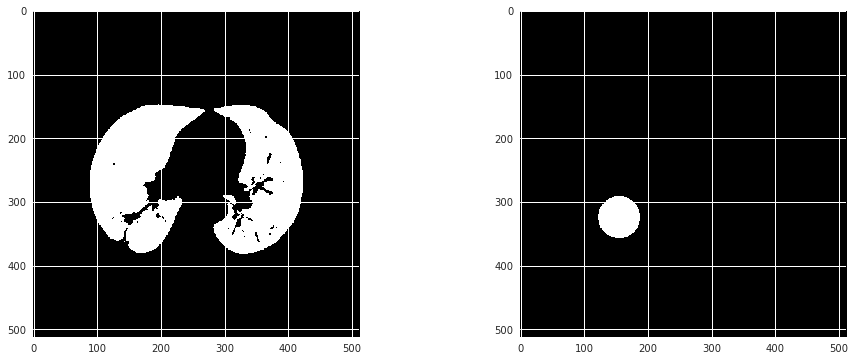

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(images[10,0,:,:],'bone')
ax[1].imshow(masks[10,0,:,:],'bone')
plt.show()

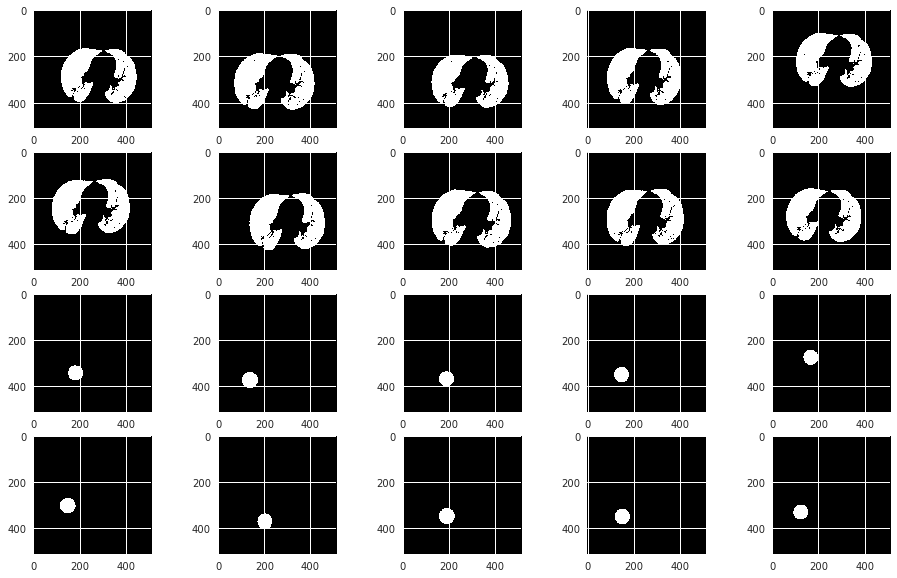

In [140]:
fig, ax = plt.subplots(4, 5, figsize=(16,10))
for i in range(5):
    for j in range(2):
        ax[j,i].imshow(a[2*i+j,0,:,:],'bone')
for t in range(5):
    for m in range(2):
        ax[2+m,t].imshow(b[2*t+m,0,:,:],'bone')
plt.show()

In [110]:
#mask也需要同步的变换才行!

In [ ]:
aug_images = np.ndarray([images.shape[0]*10,1,512,512],dtype=np.float32)
aug_masks = np.ndarray([masks.shape[0]*10,1,512,512],dtype=np.float32)
for i in tqdm(range(images.shape[0])):
    a,b = augment_images(images[i:i+1,:,:,:],masks[i:i+1,:,:,:],10)
    for j in range(10):
        aug_images[10*i+j] = a[j]
        aug_masks[10*i+j] = b[j]


  0%|          | 0/2913 [00:00<?, ?it/s]

  5%|▌         | 152/2913 [00:39<11:54,  3.86it/s]


 10%|█         | 303/2913 [01:18<11:33,  3.76it/s]


 16%|█▌        | 454/2913 [01:56<10:12,  4.02it/s]


 21%|██        | 605/2913 [02:34<09:55,  3.88it/s]


 26%|██▌       | 756/2913 [03:12<09:09,  3.92it/s]


 31%|███       | 907/2913 [03:51<08:30,  3.93it/s]


 36%|███▋      | 1057/2913 [04:32<07:57,  3.89it/s]


 41%|████▏     | 1205/2913 [05:10<07:17,  3.91it/s]


 46%|████▋     | 1353/2913 [05:50<06:49,  3.80it/s]


 52%|█████▏    | 1501/2913 [06:30<05:56,  3.96it/s]


 57%|█████▋    | 1649/2913 [07:13<05:38,  3.74it/s]


 62%|██████▏   | 1797/2913 [07:51<04:56,  3.76it/s]


 67%|██████▋   | 1945/2913 [08:33<04:07,  3.92it/s]


 70%|███████   | 2047/2913 [09:01<04:30,  3.21it/s]

In [ ]:
print (aug_images.shape)
print (aug_masks.shape)

In [ ]:
with h5py.File('preprocess/forunet/segment/augment_merge') as f:
    f.create_dataset('images',data = aug_images)
    f.create_dataset('masks',data = aug_masks)

(1, 512, 512)